# Individual Game Statistics

In this section, we analyse the 44,2016 available user inputs of Suburbia (2012), using the Ratings data available on boardgamegeek.com. (Data was saved on April 2, 2020.) Everything that is visible on the Ratings site is saved, and we are going to use four variables: the user's name, the rating they gave, whether they own the title, and their country. A rating of 0.0 indicates a missing rating. 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv('./json_data/game_123260/123260_summary_detailed.csv', header = None, 
                 names = ['user_name', 'rating','owned','country'])

The data we are working in is in this format, showing first 20 rows: 

In [11]:
df.head(20)

,user_name,rating,owned,country
0,quickfics,8.00,True,United States
1,ChrisManoll,7.22,True,Canada
2,dbec,5.00,True,NaN
3,Ericagradus,6.50,True,United Kingdom
4,tobimx,0.00,True,Germany
5,deputydavis,7.00,True,United States
6,sprz89,7.25,False,NaN
7,JBreidfjord,9.00,True,Canada
8,TriforceLegend,7.50,True,United States
9,berglucci,4.00,True,Sweden


In [12]:
df.shape

(44206, 4)

## Average Ratings

In [13]:
rated_df = df[df['rating']>0]

In [14]:
rated_df['rating'].describe()

count    20421.000000
mean         7.541705
std          1.251271
min          1.000000
25%          7.000000
50%          8.000000
75%          8.000000
max         10.000000
Name: rating, dtype: float64

Out of 44,2016 user inputs, 20,421 contained a rating, average rating is 7.541, which is in line with the [ratings info](https://boardgamegeek.com/boardgame/123260/suburbia/ratings) on boardgamegeek.

In [15]:
owned_df = df[df['owned'] == True]

## Ownership by Country

Calculating total number of owners per country, charting top 20. 

In [17]:
ownership_per_country = owned_df.groupby('country')['owned'].sum().sort_values(ascending = False)

In the next table, we show the top 20 countries by total ownership of the game. 

In [18]:
ownership_per_country[:20].astype(int)

country
United States     9701
Canada            1589
United Kingdom    1040
Germany            823
Australia          549
Italy              352
Sweden             335
Poland             332
Brazil             321
France             297
Netherlands        226
Belgium            217
Spain              213
Denmark            136
Japan              123
Finland            119
Russia             118
Taiwan              89
Norway              87
Switzerland         86
Name: owned, dtype: int64

9,701 boardgamegeek user reported owning the game in the U.S., 1,589 from Canada, etc. 

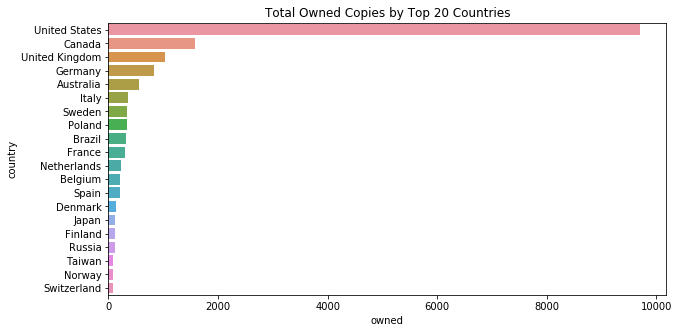

In [55]:
plt.figure(figsize = (10,5))
sns.barplot(y = ownership_per_country[:20].index, x = ownership_per_country[:20])
plt.title('Total Owned Copies by Top 20 Countries')
plt.show()

## Average Ratings per Country

Calculating average ratings per country, charting top 20. 

In [19]:
rating_per_country = rated_df.groupby('country')['rating'].mean().sort_values(ascending = False)

In the next table, we show the top 20 countries by average rating of the game. 

In [20]:
rating_per_country[:20]

country
Bosnia and Herzegovina    10.000000
Guatemala                  9.666667
Ecuador                    9.100000
Abkhazia                   9.000000
Martinique                 9.000000
El Salvador                8.850000
Honduras                   8.800000
Paraguay                   8.700000
Cape Verde                 8.500000
Vietnam                    8.487000
Slovenia                   8.191667
Saudi Arabia               8.142857
Uruguay                    8.125000
Bahrain                    8.125000
Dominican Republic         8.000000
Fiji                       8.000000
Ghana                      8.000000
Greenland                  8.000000
Åland                      8.000000
Chile                      7.996296
Name: rating, dtype: float64

Average rating is 10.00 in Bosnia and Herczegovina, 9.67 in Guatemala, etc. 

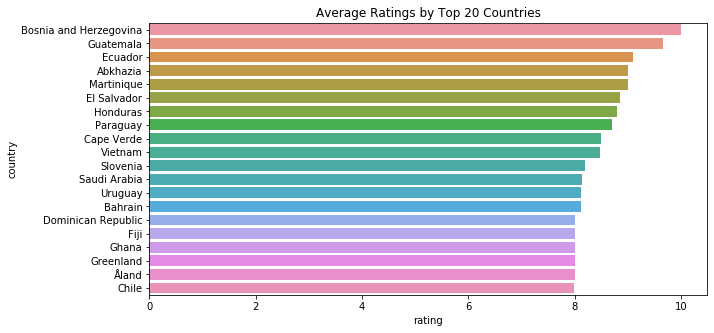

In [56]:
plt.figure(figsize = (10,5))
sns.barplot(y = rating_per_country[:20].index, x = rating_per_country[:20])
plt.title('Average Ratings by Top 20 Countries')
plt.show()

## Drawing Scatterplot of Total Owners vs Average Ratings

Plotting individual countries, x coordinate is average rating, y coordinate is total number of copies, on a logarithmic scale. 

In [21]:
country_list = list(df['country'].unique())

In [22]:
def get_rating_per_county(country):
    if country in rating_per_country.index:
        return rating_per_country[country]
    else:
        return np.nan

In [23]:
rating_list = list(map(get_rating_per_county, country_list))

In [24]:
def get_owners_per_county(country):
    if country in ownership_per_country.index:
        return np.log(ownership_per_country[country])
    else:
        return np.nan

In [25]:
ownership_list = list(map(get_owners_per_county, country_list))

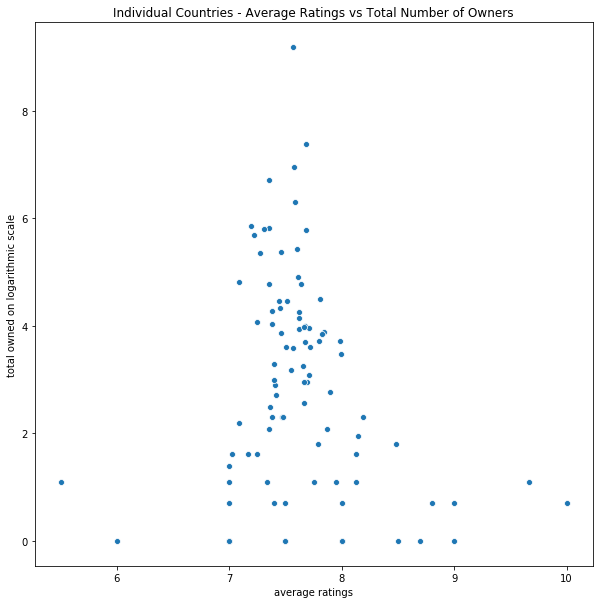

In [27]:
plt.figure(figsize = (10,10))
sns.scatterplot(rating_list,ownership_list)
plt.xlabel('average ratings')
plt.ylabel('total owned on logarithmic scale')
plt.title('Individual Countries - Average Ratings vs Total Number of Owners')
plt.show()

Countries where a lot of users own the game have an average ratings between 7 and 8, and extreme low and extreme high ratings occur in countries with a few owned copies of the game. 

# Distance from Other Games

In this section, we calculate the distance between games using two distance metrics: cosine and Pearson-correlation, based on the ratings users gave. 

In [58]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader

from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

from surprise.prediction_algorithms import knns

from surprise.similarities import cosine, msd, pearson

import pandas as pd

import bgg_data_func
import bgg_model_func
from game_name_converter import NameConverter

In [30]:
file_path = './data_input/w_suburbia_summary.csv'

reader = Reader(line_format='user item rating', sep=',', rating_scale = (1,10))

data = Dataset.load_from_file(file_path, reader=reader)

In [32]:
trainset = data.build_full_trainset()
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  217152 

Number of items:  50 



In [33]:
trainset_iids = list(trainset.all_items())
iid_converter = lambda x: trainset.to_raw_iid(x)
trainset_raw_iids = list(map(iid_converter, trainset_iids))

In [34]:
name_converter = NameConverter('games_master_list.csv')

## Cosine Difference

In [36]:
sim_cos = {'name':'cosine', 'user_based':False}
basic_cos = knns.KNNBasic(sim_options=sim_cos)
basic_cos.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [59]:
df = bgg_model_func.return_top_similar_dataframe(basic_cos.sim, trainset_raw_iids, 3)
for column in df.columns:
    df[column] = df[column].map(name_converter.get_game_name_from_id)
df.sort_values(['game'], inplace = True, axis = 0)

Next, we show the 50 games, in similar_1 column is the game that is closest by the defined distance metric, __cosine distance__, similar_2 is 2nd closest, similar_3 is 3rd closest. 

In [60]:
df

,game,similar_1,similar_2,similar_3
48,7 Wonders,7 Wonders Duel,Orléans,Azul
15,7 Wonders Duel,7 Wonders,Azul,Orléans
22,A Feast for Odin,Caverna: The Cave Farmers,Clans of Caledonia,Great Western Trail
28,Agricola,Caverna: The Cave Farmers,Le Havre,Puerto Rico
47,Anachrony,Clans of Caledonia,Orléans,Great Western Trail
46,Android: Netrunner,Arkham Horror: The Card Game,Star Wars: Rebellion,7 Wonders Duel
19,Arkham Horror: The Card Game,Mansions of Madness: Second Edition,Star Wars: Imperial Assault,Star Wars: Rebellion
42,Azul,7 Wonders Duel,Orléans,Concordia
30,Blood Rage,7 Wonders Duel,Scythe,Star Wars: Rebellion
3,Brass: Birmingham,Brass: Lancashire,Clans of Caledonia,Great Western Trail


Showing the games closest to Suburbia based on cosine distance next: 

In [38]:
df[df['game'] == 'Suburbia']

,game,similar_1,similar_2,similar_3
49,Suburbia,Clans of Caledonia,Gaia Project,A Feast for Odin


## Pearson-correlation Difference

In [39]:
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [61]:
df = bgg_model_func.return_top_similar_dataframe(basic_pearson.sim, trainset_raw_iids, 3)
for column in df.columns:
    df[column] = df[column].map(name_converter.get_game_name_from_id)
df.sort_values(['game'], inplace = True)

Next, we show the 50 games, in similar_1 column is the game that is closest by the defined distance metric, __correlation__, similar_2 is 2nd closest, similar_3 is 3rd closest. 

In [62]:
df

,game,similar_1,similar_2,similar_3
48,7 Wonders,7 Wonders Duel,Orléans,Wingspan
15,7 Wonders Duel,7 Wonders,Viticulture Essential Edition,Orléans
22,A Feast for Odin,Caverna: The Cave Farmers,Clans of Caledonia,Anachrony
28,Agricola,Caverna: The Cave Farmers,Le Havre,Puerto Rico
47,Anachrony,Scythe,Nemesis,Clans of Caledonia
46,Android: Netrunner,Twilight Imperium (Fourth Edition),Arkham Horror: The Card Game,War of the Ring (Second Edition)
19,Arkham Horror: The Card Game,Mansions of Madness: Second Edition,The 7th Continent,Star Wars: Imperial Assault
42,Azul,Wingspan,Orléans,7 Wonders Duel
30,Blood Rage,Scythe,Star Wars: Rebellion,Mechs vs. Minions
3,Brass: Birmingham,Brass: Lancashire,Great Western Trail,Clans of Caledonia


The games closest to Suburbia based on correlation: 

In [41]:
df[df['game'] == 'Suburbia']

,game,similar_1,similar_2,similar_3
49,Suburbia,Pandemic Legacy: Season 2,Orléans,Through the Ages: A New Story of Civilization
